# Objective

1. Given data for the last N days of ETF pricing data, this model aims to predict for the N + H days in the future
2. Utilizing Prophet & LSTM as models to forecast time-series data

In [60]:
import pandas as pd
import numpy as np
import time
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from fbprophet import Prophet

In [49]:
# reading the dataset
# 5 years worth of pricing data
df = pd.read_csv('SPY.csv')

# convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

# remove spaces in col headers
df.columns = [str(i).lower().replace(' ','_') for i in df.columns]

# sort values by datetime
df.sort_values(by = 'date', inplace = True, ascending = True)

df.head()

,date,open,high,low,close,adj_close,volume
0,2015-06-15,208.639999,209.449997,207.789993,209.110001,189.227280,124384200
1,2015-06-16,208.929993,210.350006,208.720001,210.250000,190.258896,85308200
2,2015-06-17,210.589996,211.320007,209.360001,210.589996,190.566559,126708600
3,2015-06-18,211.309998,213.339996,210.630005,212.779999,192.548340,165867900
4,2015-06-19,211.460007,211.550003,210.360001,210.809998,191.693558,130478700


Text(0, 0.5, 'USD')

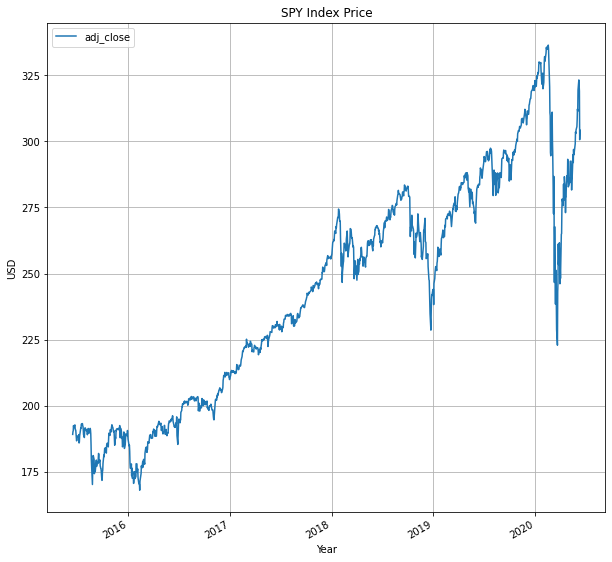

In [50]:
# Plot adjusted closing price of ETF over time
plt = df.plot(x = 'date', y = 'adj_close', linestyle='-', figsize = [10,10], grid = True)
plt.set_title('SPY Index Price')
plt.set_xlabel('Year')
plt.set_ylabel('USD')

### Preparing for Prophet
Prophet takes in 2 columns as default, which are ds and the y value. These 2 columns must be present be fed to the Prophet model.

In [51]:
# Create new dataframe for Prophet
# Prophet always takes in 2 columns only, DS & Y

df_prophet = df[['date', 'adj_close']].rename(columns = {'date':'ds', 'adj_close':'y'})
df_prophet.tail()

,ds,y
1254,2020-06-08,323.200012
1255,2020-06-09,320.790009
1256,2020-06-10,319.000000
1257,2020-06-11,300.609985
1258,2020-06-12,304.209991


In [52]:
# based on historical data, we want to predict prices for the next 30 days, which will be the forecast horizon
H = 30

In [53]:
# Fitting Prophet model
m = Prophet()
m.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [54]:
# Create new dataframe with dates we want to predict
future = m.make_future_dataframe(periods = H)

In [55]:
# remove weekends from future dataframe, since we do not need to predict weekend data
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.weekday.html
# https://facebook.github.io/prophet/docs/non-daily_data.html

future['day'] = future['ds'].dt.weekday
future = future[future['day'] <5]

forecast = m.predict(future)

In [56]:
# double check if we have values for future predictions
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1274,2020-07-06,299.920586,287.198257,312.690726
1275,2020-07-07,300.550740,288.367284,312.170168
1276,2020-07-08,300.707556,288.266596,313.138651
1277,2020-07-09,301.050752,288.982017,313.386186
1278,2020-07-10,301.360097,288.595285,313.267818


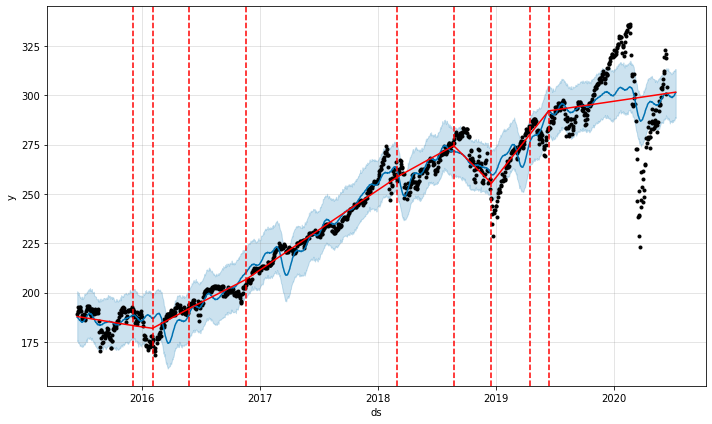

In [74]:
# plot the forecast
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast);

# add changepoints
a = add_changepoints_to_plot(fig.gca(), m, forecast)

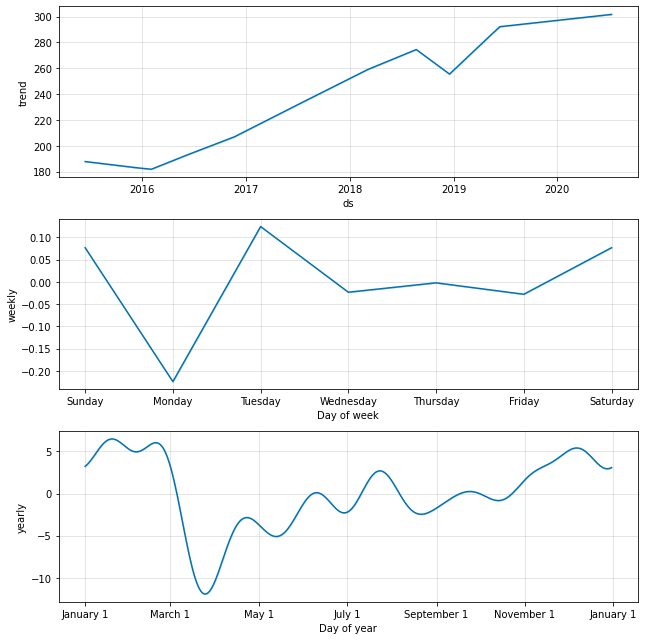

In [58]:
# plot components
m.plot_components(forecast);

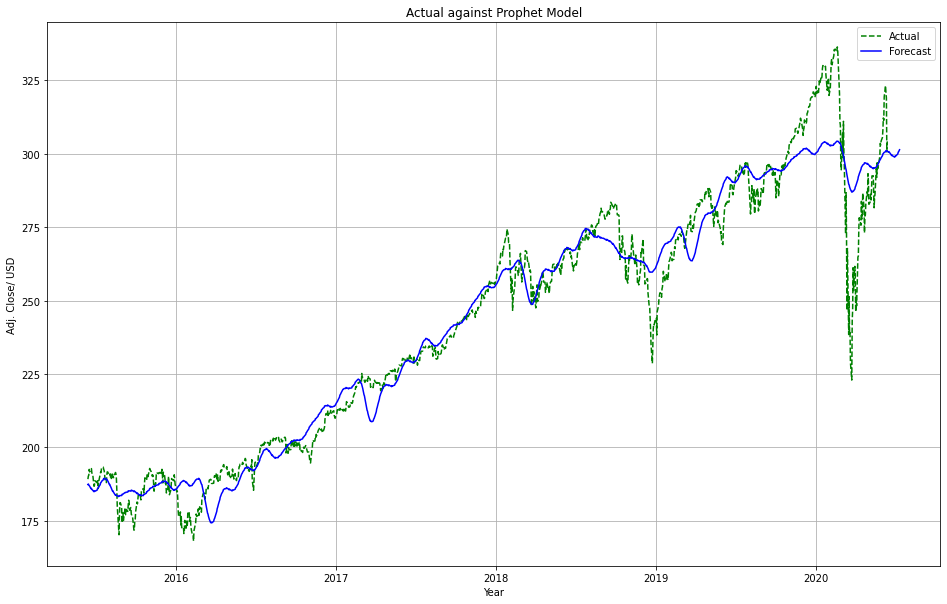

In [61]:
# Plotting the acutal plot against the forecast
plt.rcParams["figure.figsize"] = [16,10]
fig, ax = plt.subplots()
ax.plot('date','adj_close', linestyle='--', color='g', data = df)
ax.plot('ds', 'yhat', linestyle='-', color='b', data = forecast)

ax.set_title('Actual against Prophet Model')
ax.legend(['Actual','Forecast'])
ax.xaxis.set_label_text('Year')
ax.yaxis.set_label_text('Adj. Close/ USD')
ax.grid(True)
plt.show()

## Tweaking the model

From the plot above, the forecasted model does generally follow the acutal data, but we want to improve the prediction accuracy of the Prophet model to get a more reliable forecast of future values. 

In [62]:
# Evaluating accuracy of time series model with error metrics 
# Use these metrics to evaluate our prediction accuracy

# MAPE - mean absolute percentage error
def get_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MAE - mean absolute error
def get_mae(x, y):
    return np.mean(abs(np.array(x)-np.array(y)))

# RMSE - root mean squared error
def get_rmse(x, y):
    return math.sqrt(np.mean((np.array(x)-np.array(y))**2))

In [63]:
# Compare original dataframe and forecast model
print("MAPE: " + str(get_mape(df['adj_close'], forecast['yhat'][:-20])) + '\n' +
      "MAE: " + str(get_mae(df['adj_close'], forecast['yhat'][:-20])) + '\n' +
      "RMSE: " + str(get_rmse(df['adj_close'], forecast['yhat'][:-20]))
)

MAPE: 2.694284813514794
MAE: 6.558316223460894
RMSE: 9.664222949035862


# Tuning the model
https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3
https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/

In [13]:
# Count the total possible models that can arrive from the various model tuning parameters
# Parameters such as mode of seasonality, fourier order, the number of changepoints and their scale

from sklearn.model_selection import ParameterGrid
params_grid = {'fourier_order':[10,12,15,17,20],
               'changepoint_prior_scale':[0.05, 0.1, 0.5, 1, 1.5, 2],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
count = 0
for p in grid:
    count = count+1

print('Total Possible Models',count)

Total Possible Models 90


In [22]:
# Prophet model tuning
model_parameters = pd.DataFrame(columns = ['MAPE', 'MAE', 'RMSE', 'Parameters'])

start = time.time()
counter = 0

for p in tqdm(grid):
    random.seed(10)
    m = Prophet(seasonality_mode = 'additive',
                          changepoint_prior_scale = p['changepoint_prior_scale'],
                          n_changepoints = p['n_changepoints'],
                          daily_seasonality = True,
                          weekly_seasonality = True,
                          yearly_seasonality = True, 
                          interval_width = 0.95)
    
    #iterate through fourier_order
    m.add_seasonality(name='monthly', period=H, fourier_order= int(p['fourier_order']))
                
    # fit our Prophet-ready dataframe
    m.fit(df_prophet)
    future = m.make_future_dataframe(periods = H)
    
    # remove weekends from our dataframe
    future['day'] = future['ds'].dt.weekday
    future = future[future['day'] <5]
    forecast = m.predict(future)
    
    # compute error metrics
    MAPE = get_mape(df['adj_close'], forecast['yhat'][:-20])
    MAE = get_mae(df['adj_close'], forecast['yhat'][:-20])
    RMSE = get_rmse(df['adj_close'], forecast['yhat'][:-20])
    
    # increase counter
    counter +=1    
    model_parameters = model_parameters.append({'MAPE':MAPE, 'MAE':MAE, 'RMSE':RMSE, 'Parameters':p}, 
                                               ignore_index=True)
    
end = time.time()
print("Time taken:" + end-start)

100%|██████████| 90/90 [34:31<00:00, 23.02s/it]


TypeError: can only concatenate str (not "float") to str

In [40]:
# Export results to CSV
model_parameters.to_csv('tuning_results.csv')

# Sort parameters by descending MAPE
model_parameters.sort_values(by = ['MAPE', 'MAE', 'RMSE'])

# Model 79 provides the best results
#grid[79]

,MAPE,MAE,RMSE,Parameters
79,0.997168,2.430706,3.796609,"{'changepoint_prior_scale': 2, 'fourier_order'..."
65,1.001904,2.449694,3.877306,"{'changepoint_prior_scale': 1.5, 'fourier_orde..."
86,1.002560,2.454603,3.855812,"{'changepoint_prior_scale': 2, 'fourier_order'..."
75,1.004296,2.461398,3.847620,"{'changepoint_prior_scale': 2, 'fourier_order'..."
74,1.007704,2.471392,3.871515,"{'changepoint_prior_scale': 1.5, 'fourier_orde..."
...,...,...,...,...
7,2.679609,6.503413,9.563189,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
1,2.688874,6.529154,9.597732,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
11,2.696432,6.544100,9.606365,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
12,2.701845,6.559353,9.622880,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."


In [38]:
# Train final model with parameters
final_model = Prophet(seasonality_mode='additive', n_changepoints= 150, changepoint_prior_scale = 2)
final_model.add_seasonality(name='monthly', period=H, fourier_order= 12)

# Fit final model
final_model.fit(df_prophet)
future = final_model.make_future_dataframe(periods = H)

# remove weekends
future['day'] = future['ds'].dt.weekday
future = future[future['day'] <5]
forecast_final = final_model.predict(future)
forecast_final.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-06-15,185.108240,184.046654,194.152447,185.108240,185.108240,3.743434,3.743434,3.743434,-0.234738,...,0.697758,0.697758,0.697758,3.280414,3.280414,3.280414,0.0,0.0,0.0,188.851673
1,2015-06-16,184.967569,184.316118,194.208753,184.967569,184.967569,4.461757,4.461757,4.461757,-0.060673,...,0.900476,0.900476,0.900476,3.621954,3.621954,3.621954,0.0,0.0,0.0,189.429326
2,2015-06-17,184.826898,184.322604,194.444992,184.826898,184.826898,4.755508,4.755508,4.755508,-0.174450,...,1.004798,1.004798,1.004798,3.925160,3.925160,3.925160,0.0,0.0,0.0,189.582406
3,2015-06-18,184.686227,184.089866,194.153551,184.686227,184.686227,4.241196,4.241196,4.241196,-0.855863,...,0.904628,0.904628,0.904628,4.192431,4.192431,4.192431,0.0,0.0,0.0,188.927423
4,2015-06-19,184.545557,184.938250,194.652752,184.545557,184.545557,5.106909,5.106909,5.106909,-0.176770,...,0.857044,0.857044,0.857044,4.426636,4.426636,4.426636,0.0,0.0,0.0,189.652465


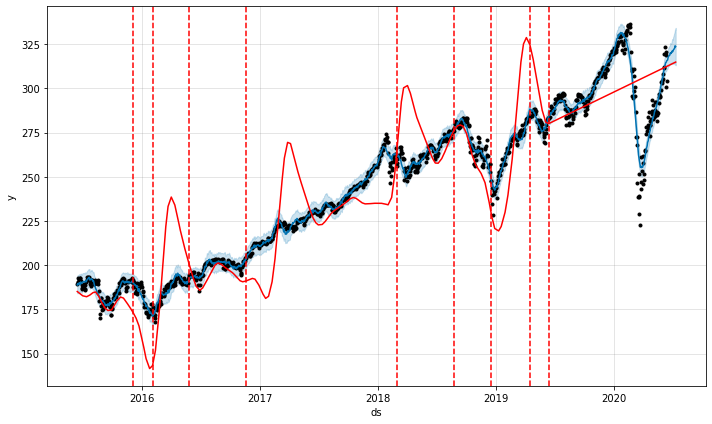

In [78]:
# plot graphs
fig2 = final_model.plot(forecast_final);

# with changepoints
a = add_changepoints_to_plot(fig2.gca(), m, forecast_final)

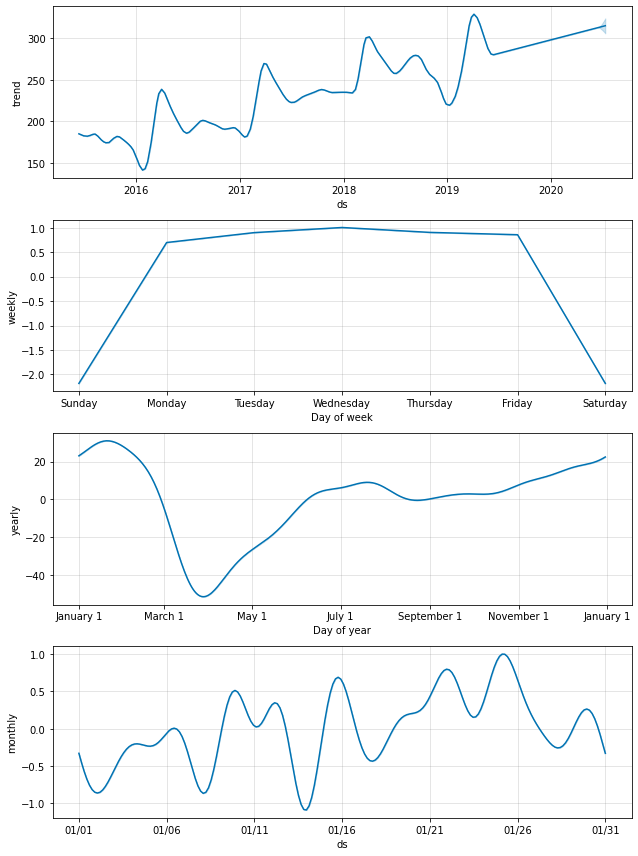

In [79]:
# plot components
final_model.plot_components(forecast_final);

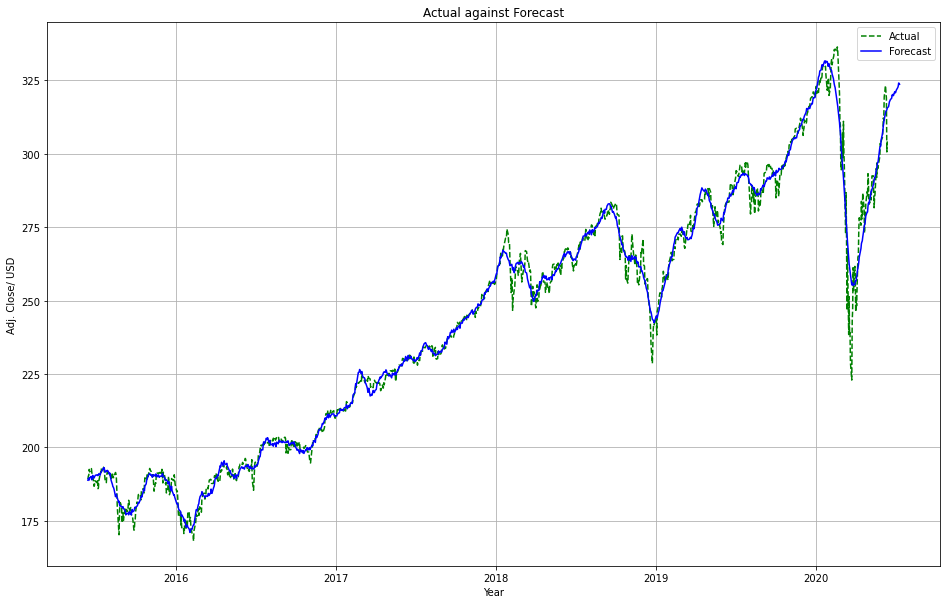

In [81]:
# plotting final model against actual data
plt.rcParams["figure.figsize"] = [16,10]
fig, ax = plt.subplots()
ax.plot('date','adj_close', linestyle='--', color='g', data = df)
ax.plot('ds', 'yhat', linestyle = '-', color='b', data = forecast_final)

ax.set_title('Actual against Forecast')
ax.legend(['Actual','Forecast'])
ax.xaxis.set_label_text('Year')
ax.yaxis.set_label_text('Adj. Close/ USD')
ax.grid(True)
plt.show()

In [85]:
start_dt = '2020-06-15'
forecasts= forecast_final[(forecast_final.ds >= start_dt)]
forecasts.yhat

1259    316.050793
1260    316.957873
1261    317.766611
1262    317.981857
1263    318.408455
1264    318.886147
1265    319.985061
1266    319.825206
1267    320.207533
1268    319.775150
1269    321.107348
1270    320.716929
1271    320.816373
1272    321.375827
1273    321.753664
1274    322.529800
1275    323.012811
1276    324.075435
1277    323.950462
1278    323.636998
Name: yhat, dtype: float64